In [1]:
!git clone https://github.com/truth771/e2e-sae.git

fatal: destination path 'e2e-sae' already exists and is not an empty directory.


In [2]:
%cd e2e-sae

/content/e2e-sae


In [67]:
!git restore . && git pull

remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 5 (delta 4), reused 5 (delta 4), pack-reused 0 (from 0)
Unpacking objects: 100% (5/5), 391 bytes | 391.00 KiB/s, done.
From https://github.com/truth771/e2e-sae
   6671b40..fd20b3b  main       -> origin/main
Updating 6671b40..fd20b3b
Fast-forward
 sae/eval/plots.py | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)


In [4]:
!pip install fairscale

In [5]:
!ls gpt2-pytorch_model.bin || curl --output gpt2-pytorch_model.bin https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-pytorch_model.bin

gpt2-pytorch_model.bin


### Plot generation

In [75]:
from sae.models import SAEParams
from sae.eval import plots
from sae.training.datasets import get_openwebtext_dataloaders, OpenWebTextConfig

In [7]:
train_loader, val_loader = get_openwebtext_dataloaders(OpenWebTextConfig(), 4)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (1106 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1086 > 1024). Running this sequence through the model will result in indexing errors


epoch 1: 100%|██████████| 2429/2429 [16:16<00:00,  2.49it/s]


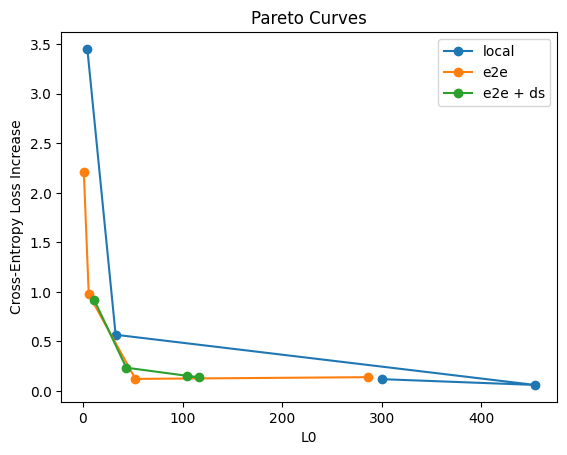

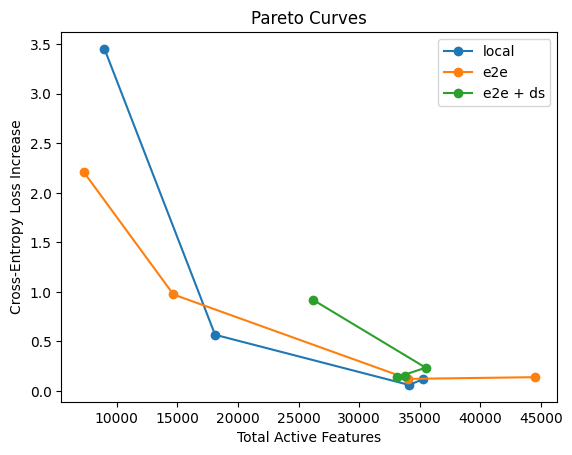

In [8]:
plots.plot_pareto_curves("gpt2", SAEParams(6, 60 * 768, None), train_loader, val_loader, device="cuda")

In [10]:
from sae.training.train import train

model_local = train("gpt2", SAEParams(6, 60 * 768, "local"), train_loader, n_epochs=1, sparsity_weight=10e-4)
model_ds = train("gpt2", SAEParams(6, 60 * 768, "e2e + ds"), train_loader, n_epochs=1, sparsity_weight=10e-2)
model_e2e = train("gpt2", SAEParams(6, 60 * 768, "e2e"), train_loader, n_epochs=1, sparsity_weight=10e-2)

epoch 1: 100%|██████████| 2429/2429 [14:41<00:00,  2.76it/s]


In [68]:
from sae.eval.active_features import eval_l0_and_active_features
from sae.eval.ce_loss import eval_ce_loss_increase
from sae.eval.plots import plot_cosine_similarity, plot_self_similarity

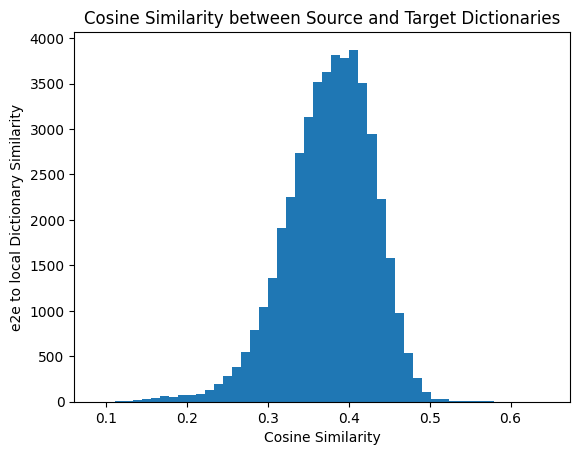

In [56]:
plot_cosine_similarity("e2e", "local", model_e2e.transformer.sae.encoder.weight.data, model_local.transformer.sae.encoder.weight.data)

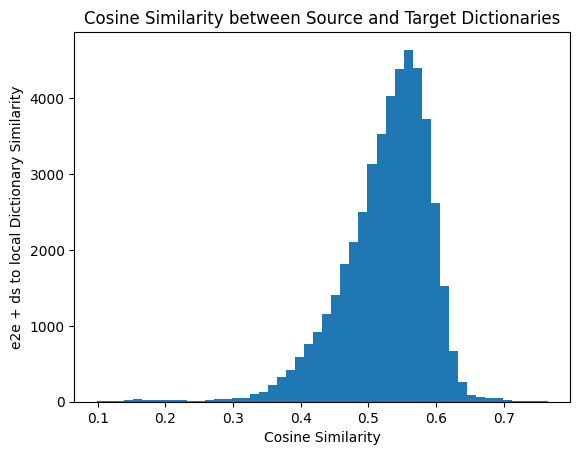

In [55]:
plot_cosine_similarity("e2e + ds", "local", model_ds.transformer.sae.encoder.weight.data, model_local.transformer.sae.encoder.weight.data)

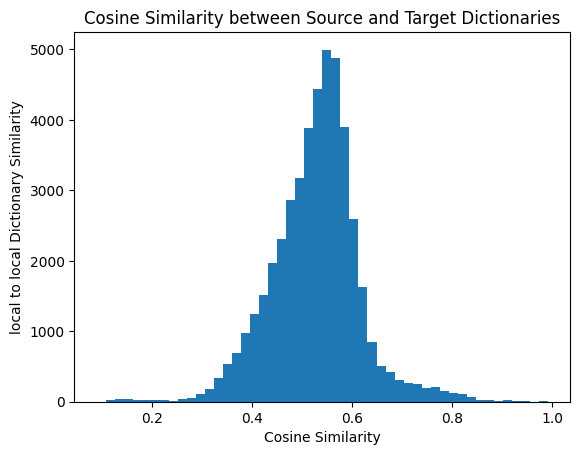

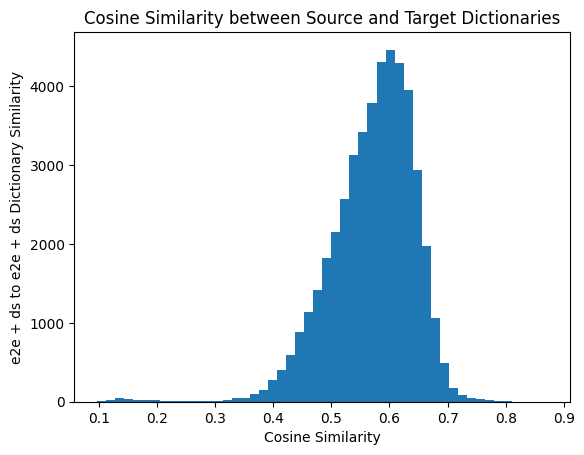

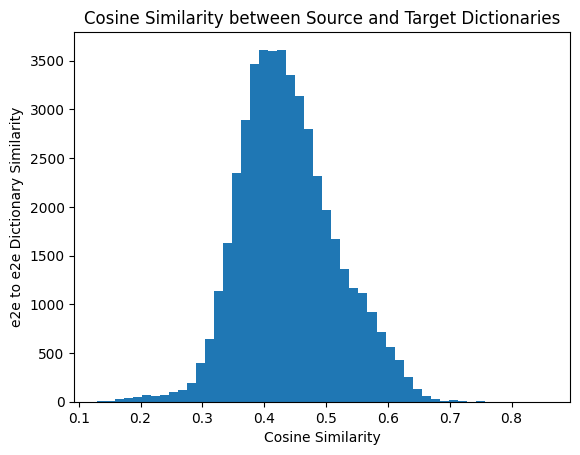

In [72]:
plot_self_similarity("local", model_local.transformer.sae.encoder.weight.data)
plot_self_similarity("e2e + ds", model_ds.transformer.sae.encoder.weight.data)
plot_self_similarity("e2e", model_e2e.transformer.sae.encoder.weight.data)

In [84]:
eval_l0_and_active_features(model_ds, val_loader, "cuda")

(96.44482560460028, 32925)

In [85]:
from sae.models import get_model, SAEParams
normal_model = get_model("gpt2", SAEParams())[0]
eval_ce_loss_increase(normal_model.cuda(), model_ds, val_loader, "cuda")


{'ce_loss_increase': 0.17694708053639394,
 'ce_original': 2.351340253283195,
 'ce_sae': 2.5282873338195886}

### Testing on openwebtext

In [77]:
train_loader_owt, val_loader_owt = get_openwebtext_dataloaders(OpenWebTextConfig(), 4, dataset_name="Elriggs/openwebtext-100k")

Token indices sequence length is longer than the specified maximum sequence length for this model (1217 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3473 > 1024). Running this sequence through the model will result in indexing errors


In [78]:
model_ds_owt = train("gpt2", SAEParams(6, 60 * 768, "e2e + ds"), train_loader_owt, n_epochs=1, sparsity_weight=10e-2)


epoch 1:  19%|█▉        | 2430/12468 [16:17<1:07:19,  2.49it/s]


In [79]:
val_loader_owt_small = [x for x, _ in zip(val_loader_owt, val_loader)]

In [81]:
eval_l0_and_active_features(model_ds_owt, val_loader_owt_small, "cuda")

(114.4068442290684, 40811)

In [83]:
eval_ce_loss_increase(normal_model.cuda(), model_ds_owt, val_loader_owt_small, "cuda")

{'ce_loss_increase': 0.8548106814330478,
 'ce_original': 3.1033988797439718,
 'ce_sae': 3.958209564101021}